<h1> Get Time corpus 1 (Co-occurence networks only) </h1>



In [1]:
#imports
import pandas as pd
import pickle
import numpy as np
from collections import Counter, OrderedDict
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

<h4> Data after Pre-Processing 1 and 2 </h4>

Variables: 
- df = Dataframe with information about title, substance, class, url, text of each report
- corpus_list = List of all the report texts concatenated 

In [2]:
df = pd.read_pickle("processed_data_3.pkl")


corpus_list = []
for text in df.text:
    corpus_list += text

<h4> Seed time perception words </h4>

- These words act as 'seeds' in the Erowid Corpus. Words surrounding the seed might describe information about time perception. 

- This list of words was generated by entering words such as 'time', 'faster', 'slower' in websites such as https://relatedwords.io/ or online synonom finders, and subjectively selecting appropriate ones. 

- Seed words consist of neutral time perception (ntp), fast time perception (ftp), and slow time perception (stp) words. Ftp and stp words were balanced (see Jupytere notebook file: '9. Other analyses').

In [3]:
ntp_words = ['time', 'period', 'periods', 'duration', 'clock', 'temporal', 'spacetime', 'timespan', 'timespans', 'timeline', 'timelines', 'elapse', 'elapsed', 'length', 'timewise', 'velocity', 'pace', 'rate', 'tempo', 'pass', 'passing', 'passed']
ftp_words = ['quick','quicker', 'quickly', 'quickest', 'fast', 'faster', 'fastest', 'fastened', 'rapid','rapidly', 'short', 'shorter', 'shortly', 'shortest','speedy', 'speedy','speeded', 'speedier', 'hurry', 'hurried', 'swift', 'swifter', 'swiftly', 'haste', 'hasty', 'brisk', 'turbo', 'accelerate', 'acceleration', 'accelerated', 'accelerating']
stp_words = ['slow', 'slower', 'slowly', 'slows', 'slowed', 'slowest', 'slowing', 'slowdown', 'long', 'looong', 'longer', 'longer', 'longest', 'steady', 'deceleration', 'decelerate', 'decelerating', 'decelerated', 'dilatory', 'dilation', 'infinity', 'eternity', 'lengthy', 'prolonged', 'protracted', 'extended', 'unending', 'endless']
time_words = sorted(ntp_words + ftp_words + stp_words)


<h4> Get context window function </h4>

- Used to iterate through a list and yield C words before and after each seed word.

In [4]:
# Get context window function for time_words
def get_windows(words, C):
    i = C
    while i < len(words) - C:
        center_word = words[i]
        if center_word not in time_words:
            i += 1
            pass
        else:
            context_words = words[(i - C):i] + words[(i+1):(i+C+1)]
            yield context_words, center_word
            i += 1

<h4> SHOULD I USE: Modified get context window (CW) function </h4>

In some context windows, there are multiple time_words. E.g.:

*"(...)to my exceptional set and setting. later on in the future .god knows how long because time was passing so fast. i was talking to my friend t on the couch that i had yet to leave(...)"*

The modified get CW function skips over any seed words (time words), if those time words are in the context window after the intial seed word ('center_word').

In [ ]:
# Modified get context window function for time_words
def modified_get_windows(words, C):
    i = C
    while i < len(words) - C:
        center_word = words[i]
        if center_word not in time_words:
            i += 1
            pass
        else:
            context_words = words[(i - C):i] + words[(i+1):(i+C+1)]
            for word in time_words:
                if word in context_words:
                    i += C
                    pass
            yield context_words, center_word
            i += 1


<h4> Context window examples </h4>

- Get context window and report url for specific time seed words. 

- Line 7 can be adjusted to get the context windows for specific seed or context words. Very useful for understanding nodes in the co-occurence network graph (later).

In [5]:
#co-occurences in context window examples

listx = []


def context_words_edges_vertices(C, listx):
    for i, text in enumerate(df.text):
        url = df.loc[i, "url"]
        for context_words, center_word in get_windows(text, C):
            #can look for specific words
            if "eskimo" in context_words: # line 7
                print(context_words[0:C])
                print(center_word)
                print(context_words[C:])
                print(url)
                print("\n")
                listx += context_words

context_words_edges_vertices(C=10, listx=listx)



['towards', 'assertive', 'point', 'assertive', 'father', 'point', 'sell', 'refrigerator', 'eskimo', 'believe']
time
['quickly', 'blast', 'muscle', 'feel', 'kind', 'tight', 'warm', 'good', 'music', 'enjoyment']
https://erowid.org/experiences/exp.php?ID=52154


['assertive', 'point', 'assertive', 'father', 'point', 'sell', 'refrigerator', 'eskimo', 'believe', 'time']
quickly
['blast', 'muscle', 'feel', 'kind', 'tight', 'warm', 'good', 'music', 'enjoyment', 'distort']
https://erowid.org/experiences/exp.php?ID=52154


['impossible', 'gauge', 'approach', 'realize', 'bridge', 'dog', 'visitor', 'calm', 'pass', 'nice']
slow
['nice', 'easy', 'fail', 'fine', 'sir', 'strange', 'tone', 'real', 'queer', 'eskimo']
https://erowid.org/experiences/exp.php?ID=39028


['person', 'dream', 'dreamworld', 'dream', 'ask', 'real', 'hey', 'eskimo', 'real', 'see']
time
['stop', 'meaning', 'space', 'abstract', 'concept', 'indian', 'real', 'life', 'eskimo', 'dreamy']
https://erowid.org/experiences/exp.php?ID=39028

<h4> Get all co-occurences in Time corpus  </h4>

- Time corpus = All context windows seeded by all time words.

- Get all pairs of word-occurence in each context window in the Time corpus. 

- Pairs stored in dataframe (df2) in the following format:


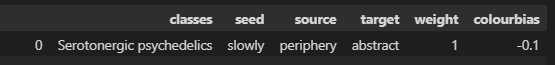


- The colourbias quantifies whether the seed word is a ntp, ftp, or stp. This score is used for visulization later. 

In [ ]:
%%time
#co-occurence network - edges
def context_words_edges_vertices(C):
    #splitting the dataframe into parts and saving locally reduces memory load on juypter notebook and speeds up code significantly
    for k in range(216): #adjust 216 - in my case reports = 21,548, so 100*216 = 21,600
        print(k)
        df2  = pd.DataFrame(columns = ["classes", "seed", "source", "target", "colourbias"])
        for i, text in enumerate(df.text[k*100:(k+1)*100]): 
            classes = df.loc[i, "classes"]
            for context_words, center_word in get_windows(text, C):
                if center_word in ntp_words:
                    all_pairs = [(a, b) for idx, a in enumerate(context_words) for b in context_words[idx + 1:]]
                    for a, b in all_pairs:
                        df2.loc[len(df2.index)] = [classes, center_word, a, b, 0]   
                elif center_word in ftp_words:
                    all_pairs = [(a, b) for idx, a in enumerate(context_words) for b in context_words[idx + 1:]]
                    for a, b in all_pairs:
                        df2.loc[len(df2.index)] = [classes, center_word, a, b, 1]
                elif center_word in stp_words:
                    all_pairs = [(a, b) for idx, a in enumerate(context_words) for b in context_words[idx + 1:]]
                    for a, b in all_pairs:
                        df2.loc[len(df2.index)] = [classes, center_word, a, b, -1]    
        df2.to_pickle("timecorpus" + str(k) + ".pkl")

    

#adjust context window C
context_words_edges_vertices(C=4)


#concatenate dataframe parts
df2  = pd.DataFrame(columns = ["classes", "seed", "source", "target", "colourbias"])
for k in range(216):
    temp = pd.read_pickle("timecorpus" + str(k) + ".pkl")
    df2 = pd.concat([df2, temp], axis=0)


#Save file
#keep "timecorpus.pkl", delete timecorpus0-215.pkl
df2.to_pickle("timecorpus_C4.pkl")